# Analysis of Elisabeta Lusso sources

Will analyse AGN sources with multiple detections in the **4XMM-DR9** catalogue, using the examples in [Eliabeta Lusso paper](https://ui.adsabs.harvard.edu/abs/2019AN....340..267L/abstract).

Elisabeta uses a homogenous sample of 791 quasars selected from SDSS-DR7 with X-ray match in 3XMM-DR7. From those, 250 have at least 2 observations.

Analysis of the fractional variation of their fluxes: she found 15-30% fractional variation on timescales of weeks/years. For observations closer to the axis, the fractional variation in smaller: 10-25%. The discrepancy is indicative to "_instrumental/calibration issues rather than true variations._"

_Jan 2020_

In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd

from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
#
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

home = os.path.expanduser('~')
lhome = home.replace('home','lhome')


In [42]:
def plot_per_band(catin,inst='M1',norm='mean', which='FLUX'):
    #
    # plot the count-rate for instrument
    #
    # if norm is 'closest' then will normalise the count-rates with the one closest to the axis
    # if norm is 'mean' then will normalise with the mean RATE or FLUX per band
    # if norm is None will nto normalise
    #
    #
    srcname = catin.SRCID.values[0]
    iauname = catin.IAUNAME.values[0].decode()
    #
    ndet = catin.shape[0]
    ndetmin = catin.N_DETECTIONS.min()
    ndetmax = catin.N_DETECTIONS.max()
    print (f"{iauname}, SRCID: {srcname}: Group contains {ndet} members and N_DETECTIONS={ndetmin},{ndetmax}")
    #
    if (ndet != ndetmin):
        print ("*** Warning: mismatch in group size and 4XMM-DR9 number of detections!")
    # off-axis angles
    off = catin[f'{inst}_OFFAX']
    # find the index of the element closer to the axis (i.e the min OFFAX)
    ixmin = off.idxmin()
    theta_min = off.min()
    xobs = catin['OBS_ID'].loc[ixmin]
    print (f"Minimum off-axis: {theta_min:.1f} arcmin from OBS_ID {xobs.decode()}")
    phi = catin[f'{inst}_phi']
    # get the max count-rate for plotting and if norm is True then renormalise
    cts_max = 0.0
    for xband in [1,2,3,4,5]:
        if (catin[f'{inst}_{xband}_{which}'].max() >= cts_max):
            cts_max = catin[f'{inst}_{xband}_{which}'].max()
    #
    # check if 4XMM sets a variability flag
    #
    vflag = catin['VAR_FLAG']
    # if there is a True flag then 
    if (vflag.any()):
        print (f"*** Some of the {ndet} detections sets the variability flag.")
    else:
        print (f"--- None of the {ndet} detections sets  the variability flag.")
    #
    fig = plt.figure(figsize=(12,15))
    cmx = plt.cm.get_cmap('hsv')
    #cmx = plt.cm.get_cmap('RdYlBu')
    #
    for xband in [1,2,3,4,5]:
        #
        if (norm == 'closest'):
            cts0 = catin[f'{inst}_{xband}_{which}'].loc[ixmin]
            cts0err = catin[f'{inst}_{xband}_{which}_ERR'].loc[ixmin]
            if (cts0 != 0.0):
                cts = catin[f'{inst}_{xband}_{which}']/cts0
            else:
                cts = catin[f'{inst}_{xband}_{which}']*0
            if (cts0err != 0 and catin[f'{inst}_{xband}_{which}'].any() != 0.0):
                cts_err = cts*np.sqrt((catin[f'{inst}_{xband}_{which}_ERR']/catin[f'{inst}_{xband}_{which}'])**2 + (cts0err/cts0)**2)
            else:
                cts_err = catin[f'{inst}_{xband}_{which}']*0
        elif (norm == 'mean'):
            cts0 = np.mean(catin[f'{inst}_{xband}_{which}'])
            if (cts0 > 0.0):
                cts = catin[f'{inst}_{xband}_{which}']/cts0
                cts_err = catin[f'{inst}_{xband}_{which}_ERR']/cts0
            else:
                cts = catin[f'{inst}_{xband}_{which}']*0
                cts_err = cts
        elif (norm == 'median'):
            cts0 = np.median(catin[f'{inst}_{xband}_{which}'])
            if (cts0 > 0.0):
                cts = catin[f'{inst}_{xband}_{which}']/cts0
                cts_err = catin[f'{inst}_{xband}_{which}_ERR']/cts0
            else:
                cts = catin[f'{inst}_{xband}_{which}']*0
                cts_err = cts
        else:
            cts = catin[f'{inst}_{xband}_{which}']
            cts_err = catin[f'{inst}_{xband}_{which}_ERR']
        #
        # plotting
        #
        ax = fig.add_subplot(3,2,xband)
        #
        colors = phi
        p0 = ax.errorbar(off,cts,yerr=cts_err,fmt='o',markersize=3,label='',alpha=0.3)
        #p0 = ax.errorbar(off,cts,yerr=cts_err,fmt='o',markersize=3,label=f'CTS {bands[xband]}',alpha=0.3)
        p1 = ax.scatter(off,cts,c=phi,s=100,cmap=cmx,label=f'{bands[xband]}')
        ax.grid()
        ax.legend()
        #ax.legend(loc='lower left')
        if (which == 'RATE'):
            unit = 'cts/s'
            title = 'Count-rate'
        else:
            unit = 'erg/cm2/s'
            title = 'Flux'
        #
        if (norm == 'closest'):
            ax.set_title(f'Norm closest: {cts0:.2e} {unit}')
        elif (norm == 'mean'):
            ax.set_title(f'Norm mean: {cts0:.2e} {unit}')
        elif (norm == 'median'):
            ax.set_title(f'Norm median: {cts0:.2e} {unit}')
        ax.set_xlabel('Off-axis (arcmin)')
        if (norm in ['closest','mean', 'median']):
            ax.set_ylim((0.0,3.0))
            ax.axhline(1.0,color='black',linestyle='dashed')
            ax.axhline(1.2,color='black',linestyle='dotted')
            ax.axhline(0.8,color='black',linestyle='dotted')
        else:
            ax.set_ylim((cts.min()*0.9,cts.max()*1.1))
        if (xband==3):
            if (norm in ['closest','mean', 'median']):
                ax.set_ylabel(f'{inst}: {title} ratio')
            else:
                ax.set_ylabel(f'{inst}: {title}')
        if (xband == 5):
            cbar = plt.colorbar(p1)
            cbar.set_label('Azymuth angle (deg)');
    #
    plt.suptitle(f"{title} for SRCID: {srcname}\n IAUNAME: {iauname}")
    #plt.subplots_adjust(wspace=0, hspace=0)
    #plt.savefig(f"{wdir}/figures/cts_mos1_pn_theta_3xmm.png",dpi=100)
    #plt.show()
    #plt.close();

In [3]:
def radial_diagram(dataframe,inst='M1',which='FLUX',norm=False):
#
#
# polar plot with azymuthal angles from 0 to 360 with step 30 deg and 
# 3 equal area offaxis bins from 2 to 12 arcmin.
#
    #
    iauname = dataframe.IAUNAME.values[0].decode()
    fig = plt.figure(figsize=(15,20))
    #ax = fig.add_subplot(1,1,1, projection='polar')
    cmx = plt.cm.get_cmap('RdYlBu')
    # off-axis angles
    theta = dataframe[f'{inst}_OFFAX']
    # closest to optical axis
    ixsort = np.argsort(theta)
    # azymuth
    phi = dataframe[f'{inst}_phi']
    phi_rad = np.deg2rad(phi)
    #
    for xband in [1,2,3,4,5]:
        ax = fig.add_subplot(3,2,xband, projection='polar')
        fx = dataframe[f'{inst}_{xband}_{which}']
        nobs = len(np.where(np.isfinite(fx))[0])
        if (norm):
            k = 0
            ixmin = ixsort[k]
            while (dataframe[f'{inst}_{xband}_{which}'].loc[ixmin] <= 0.0):
                ixmin = ixsort[k]
                k += 1
            cts0 = dataframe[f'{inst}_{xband}_{which}'].loc[ixmin]
            cts0err = dataframe[f'{inst}_{xband}_{which}_ERR'].loc[ixmin]
            #print (xband,cts0)
            # normalise
            cts = dataframe[f'{inst}_{xband}_{which}']/cts0
            cts_err = cts*np.sqrt((dataframe[f'{inst}_{xband}_{which}_ERR']/dataframe[f'{inst}_{xband}_{which}'])**2 + (cts0err/cts0)**2)
        else:
            cts = dataframe[f'{inst}_{xband}_{which}']
            cts_err = dataframe[f'{inst}_{xband}_{which}_ERR']
        #
        colors = cts
        p1 = ax.scatter(phi_rad,theta,c=colors,cmap=cmx,s=100, alpha=0.7)
        ax.set_yticks([2.0,6,8.0,10.0,12.0,14.0])
        ax.set_ylim((0,15))
        ax.set_title(f'Band {bands[xband]}')
        #if (xband == 2):
        cbar = plt.colorbar(p1)
        cbar.set_label(f'{inst} {which}');
        #
    fig.suptitle(f'Azymuthal and ratial distribution of {which} for source {iauname} \n n={nobs}')
    #plt.subplots_adjust(wspace=0.1, hspace=0)
    #plt.savefig(f"{wdir}/figures/flux_azymuth_theta_mos1_pn.png",dpi=100)
    plt.show()
    #plt.close();

In [4]:
def select_by_iauname(table,iauname,inst='M1',stat=True):
    #
    # input  is an astropy Table
    # IAUNAME is the source name in the 4XMM-DR9 catalogue
    # if stat is True then will perform some statistics of the multiple detections
    # ONLY if the number of sources with IAUNAME is above 5.
    #
    mask = (table['IAUNAME'] == iauname) & (table['SUM_FLAG'] == 0) & (table['CONFUSED'] == 0) & (table['HIGH_BACKGROUND'] == 0) & \
        (np.isfinite(table[f'{inst}_ONTIME']))
    tsel = table[np.where(mask)[0]]
    nsel = len(tsel)
    print (f"Selected {nsel} entries for source with IAUNAME = {iauname}.")
    if (nsel == 0):
        #
        # search around the position and pick up the nearest neighbour
        #
        save_iauname = iauname
        coord = skyCoord_from_iauname(iauname)
        cat = SkyCoord(ra=table['RA'], dec=table['DEC'], frame='icrs')
        d2d = coord.separation(cat)
        imin = np.argmin(d2d)
        dmin = d2d[imin]
        iauname = table['IAUNAME'][imin]
        print (f"Warning: the input IAUNAME {save_iauname} does not match any source in the 4XMM catalogue")
        print (f"I found this nearest neighbour: {iauname} at {dmin.to(u.arcsec):.2f}")
        print ("Will use this new ID to extract from 4XMM catalogue")
        #
        mask = (table['IAUNAME'] == iauname) & (table['SUM_FLAG'] == 0) & (table['CONFUSED'] == 0) & (table['HIGH_BACKGROUND'] == 0) & \
            (np.isfinite(table[f'{inst}_ONTIME']))
        tsel = table[np.where(mask)[0]]
        nsel = len(tsel)
        print (f"Selected {nsel} entries for source with IAUNAME = {iauname}.")
    else:
        print (f"Found an exact name match in 4XMM catalogue")
    #
    # will work with pandas dataframe
    df = tsel.to_pandas()
    #
    if (nsel > 5):
        # filters
        filters = [xf.decode() for xf in df[f'{inst}_FILTER']]
        fig, axs = plt.subplots(ncols=3,figsize=(15,5))
        sns.countplot(filters, color='gray',ax=axs[0])
        axs[0].set_xlabel('FILTER')
        # exposure
        sns.distplot(df[f'{inst}_ONTIME']/1000.0,ax=axs[1], norm_hist=False, kde=False, axlabel=f'{inst}_ONTIME (ks)');
        # counts
        sns.distplot(df[f'{inst}_8_CTS'],ax=axs[2], norm_hist=False, kde=False, axlabel=f'{inst}_8_CTS (counts)');
        
    return df

In [5]:
def skyCoord_from_iauname_OLD(iauname):
    #
    # the IAUNAME is something like 4XMM Jhhmmss.s+ddmmss
    #
    cpart = iauname.split('J')[1]
    dpart = re.split('(-)',cpart)
    if (len(dpart) != 3):
        dpart = re.split('(\\+)',cpart)
        if (len(dpart) != 3):
            print (f"Cannot extract coordinates from {iauname}, cannot find the sign character (+/-)")
            return None
    #
    ra = dpart[0][0:2] + " " + dpart[0][2:4] + " " + dpart[0][4:]
    dec = dpart[1] + dpart[2][0:2] + " " + dpart[2][2:4] + " " + dpart[2][4:]
    return SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg))

In [6]:
def skyCoord_from_iauname(iauname):
    #
    # the IAUNAME is something like 4XMM Jhhmmss.s+ddmmss
    #
    jcoord = "".join(re.split('(J)',iauname)[1:])
    return SkyCoord(jcoord, unit=(u.hourangle, u.deg))

In [7]:
def plot_phi(dataset,inst='M1', which='RATE',relative=False, ml_limit=10.0):
    #
    # if relative is True then will plot the relative to the mean distribution
    #
    fig, axs = plt.subplots(3,2,figsize=(15,20))
    #
    for xband in [1,2,3,4,5]:
        iml = dataset[f'{inst}_{xband}_DET_ML'] >= ml_limit
        xdat = dataset[iml]
        nband  = len(xdat)
        if (nband == 0):
            continue
        #print (f"Selected {nband} sources above ML of 10")
        #
        az = xdat[f'{inst}_phi']
        #
        fx = xdat[f'{inst}_{xband}_{which}']
        fx_err = xdat[f'{inst}_{xband}_{which}_ERR']
        info = 'Absolute'
        fx_mean = np.mean(fx)
        fx_std = np.std(fx)
        if (relative):
            fx = fx/fx_mean
            fx_err = fx_err/fx_mean
            info = 'Relative'
            fx_std = np.std(fx)
        #
        irow = xband-1
        icol = 0
        if (irow > 2):
            icol=1
            irow=irow-3
        panel = irow,icol
        axs[panel].errorbar(az,fx,yerr=fx_err,fmt='o',markersize=10,\
                            label=f'{bands[xband]} n={nband}')
        if (relative):
            axs[panel].axhline(1.0,color='black',linestyle='dashed')
            axs[panel].axhline(1.0 + fx_std,color='black',linestyle='dotted')
            axs[panel].axhline(1.0 - fx_std,color='black',linestyle='dotted')
            axs[panel].axhline(1.2,color='green',linestyle='dashed')
            axs[panel].axhline(0.8,color='green',linestyle='dashed')
            axs[panel].text(250.0,2.5,f'St.dev: {fx_std:.2f}')
            axs[panel].set_ylim((0,3))        
        else:
            axs[panel].axhline(fx_mean,color='black',linestyle='dashed')
            axs[panel].axhline(fx_mean + fx_std,color='black',linestyle='dotted')
            axs[panel].axhline(fx_mean - fx_std,color='black',linestyle='dotted')
            #axs[panel].set_ylim((0,3))        
        axs[panel].grid()
        axs[panel].legend(loc='upper left')
        #axs[panel].set_xlabel('Energy band')
        if (irow==1 and icol==0):
            axs[panel].set_ylabel(f'{info} {inst} {which}')
        axs[panel].set_xlim((0,360))
        #axs[panel].set_ylim((0,3))        
        if (icol > 0):
            axs[panel].set_yticklabels([])
        if (irow == 0 or (irow==1 and icol==0)):
            axs[panel].set_xticklabels([])
        if (irow == 2):
            axs[panel].set_xlabel('Azymuth (deg)')
    #
    axs[panel].set_xlabel('Azymuth (deg)')
    #
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.delaxes(axs[2,1])
    plt.show()


## Energy bands used in 3XMM

```Basic energy bands: 	
1 	= 	0.2 -   0.5 keV 	 
2 	= 	0.5 -   1.0 keV 	  	 
3 	= 	1.0 -   2.0 keV 	  	 
4 	= 	2.0 -   4.5 keV 	  	 
5 	= 	4.5 - 12.0 keV 	  	 
Broad energy bands: 	
6 	= 	0.2 -   2.0 keV 	  	soft band, no images made, not used
7 	= 	2.0 - 12.0 keV 	  	hard band, no images made, not used
8 	= 	0.2 - 12.0 keV 	  	total band
9 	= 	0.5 -   4.5 keV 	  	XID band
```

In [8]:
#
# define the energy ranges for text info
#
bands = {1:'[0.2-0.5] keV',2:'[0.5-1.0] keV',3:'[1.0-2.0] keV',4:'[2.0-4.5] keV',5:'[4.5-12.0] keV',\
        8:'[0.2-12.0] keV'}


In [9]:
#
# read the 3XMM-DR8/4XMM-DR9 catalogue, my version with azymuthal angles in
#
wdir = f'{home}/Works/XMM/4XMM'
t4 = Table.read(f'{wdir}/4XMM_DR9cat_v1.1_azymuth.fits.gz')

In [10]:
#
# in the field of 3C273
# from Lusso paper, n=30, min_theta M1 = 5.2 arcmin
#srcid = '4XMM J122931.2+015248'
#
# from esasky source with n=37, min_theta M1 = 3.4 arcmin
#srcid = '4XMM J122942.4+015524'
# from esasky source with n=38, min_theta M1 = 7.9 arcmin
#srcid = '4XMM J122837.1+015720'
# from esasky source with n=37, min_theta M1 = 1.1 arcmin
#srcid = '4XMM J122934.7+015657'
#
# in the field of 1E0102-72.2
# from esasky source with n=51, min_theta M2 = 1.9 arcmin (no MOS1 and PN)
#srcid = '4XMM J010143.2-715431'
# from esasky source with n=43, min_theta M1 = 8.2 arcmin, NO GOOD
#srcid = '4XMM J010540.1-720726'
# from esasky source with n=15, min_theta M1 = 0.8 arcmin, NO GOOD
#srcid = '4XMM J010337.5-720132'
#
# in the field of LMC N132D, n=35 for MOS1, min_theta M1 = 8.7 arcmin, Good example
srcid = '4XMM J052716.0-693933'

# in the field of LMC N132D, n=31 for MOS1
#srcid = '4XMM J052627.6-693425'
# in the field of LMC N132D, n=31 for MOS1
#srcid = '4XMM J052538.4-693543'
# star in the field of LMC N132D, n=4 for MOS1, min_theta M1 = 8.7 arcmin
#srcid = '4XMM J052538.3-693543'

# in the field of LMC N132D, n=34 for MOS1, min_theta M1 = 7.6 arcmin
#srcid = "2XMM J052552.5-694456"

#mask = (t4['IAUNAME'] == srcid) & (t4['SUM_FLAG'] == 0) & (t4['CONFUSED'] == 0) & (t4['HIGH_BACKGROUND'] == 0)
#tsel = t4[np.where(mask)[0]]
#print (f"Selected {len(tsel)} entries for source with IAUNAME = {srcid}")
#
# convert to pandas
#
#df = tsel.to_pandas()

Selected 35 entries for source with IAUNAME = 4XMM J052716.0-693933.
Found an exact name match in 4XMM catalogue


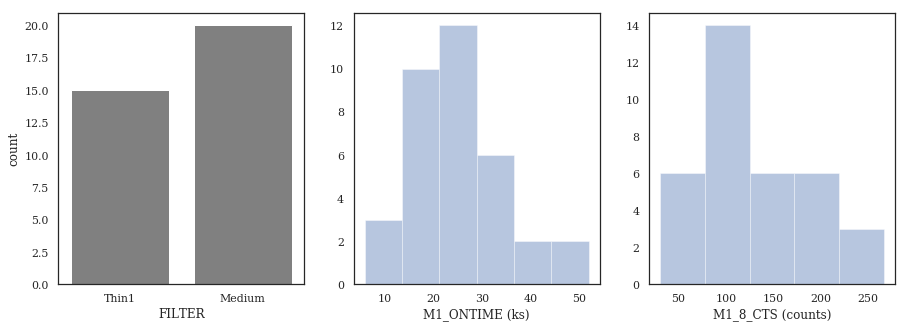

In [12]:
qf = select_by_iauname(t4,srcid,inst='M1')

4XMM J052716.0-693933, SRCID: 201251001010006: Group contains 35 members and N_DETECTIONS=41,41
*** Warning: mismatch in group size and 4XMM-DR9 number of detections!
Minimum off-axis: 8.7 arcmin from OBS_ID 0137551301
--- None of the 35 detections sets  the variability flag.


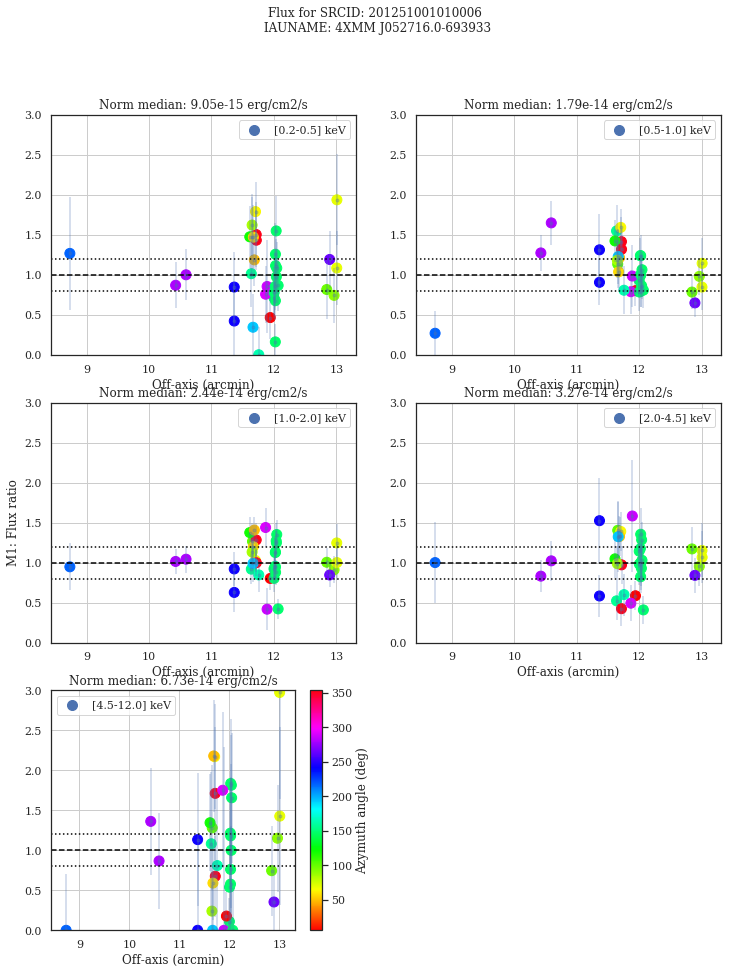

In [43]:
plot_per_band(qf,inst='M1',norm='median')

## Radial plots

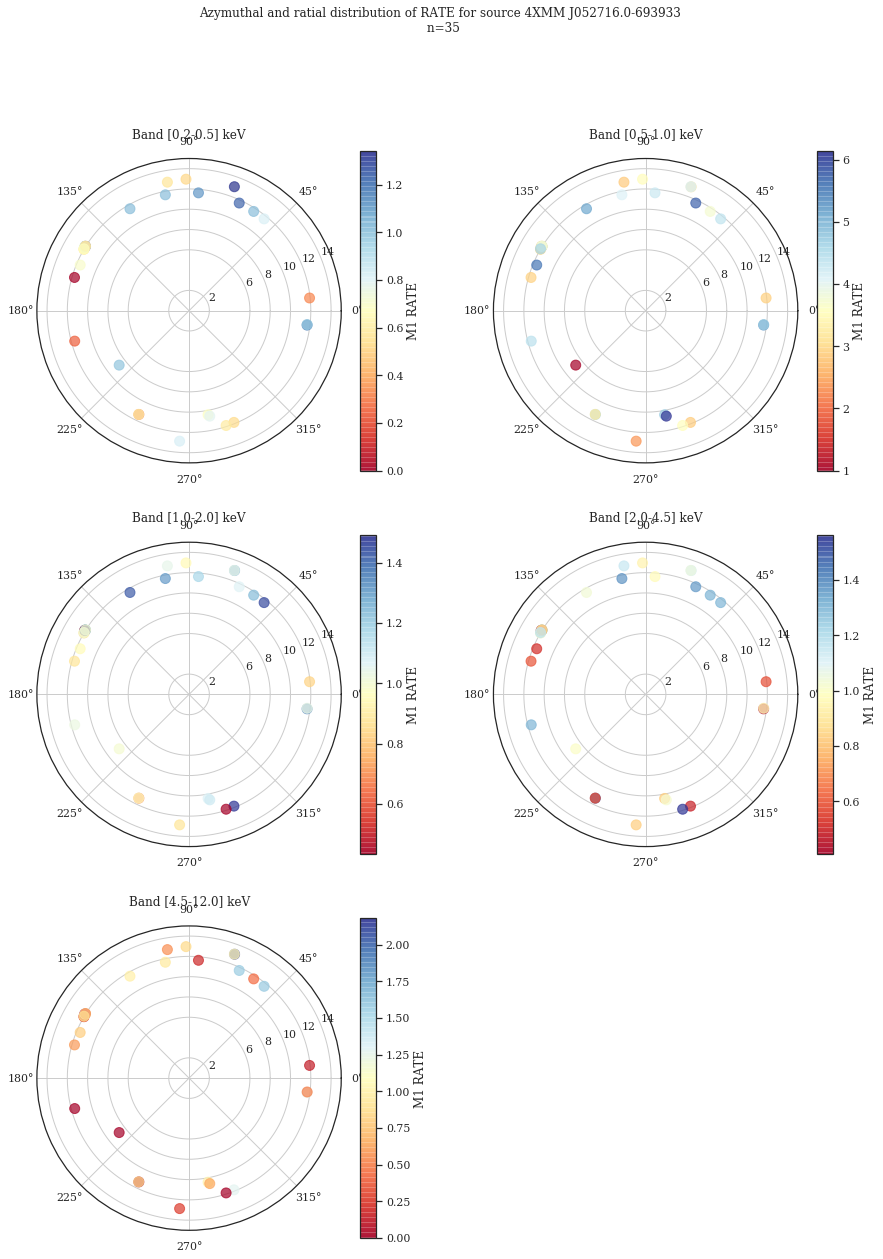

In [14]:
radial_diagram(qf, inst='M1', which='RATE',norm=True)

## Azymuthal plot

Only makes sense if there are enough spread in the azymuth angles for the particular source

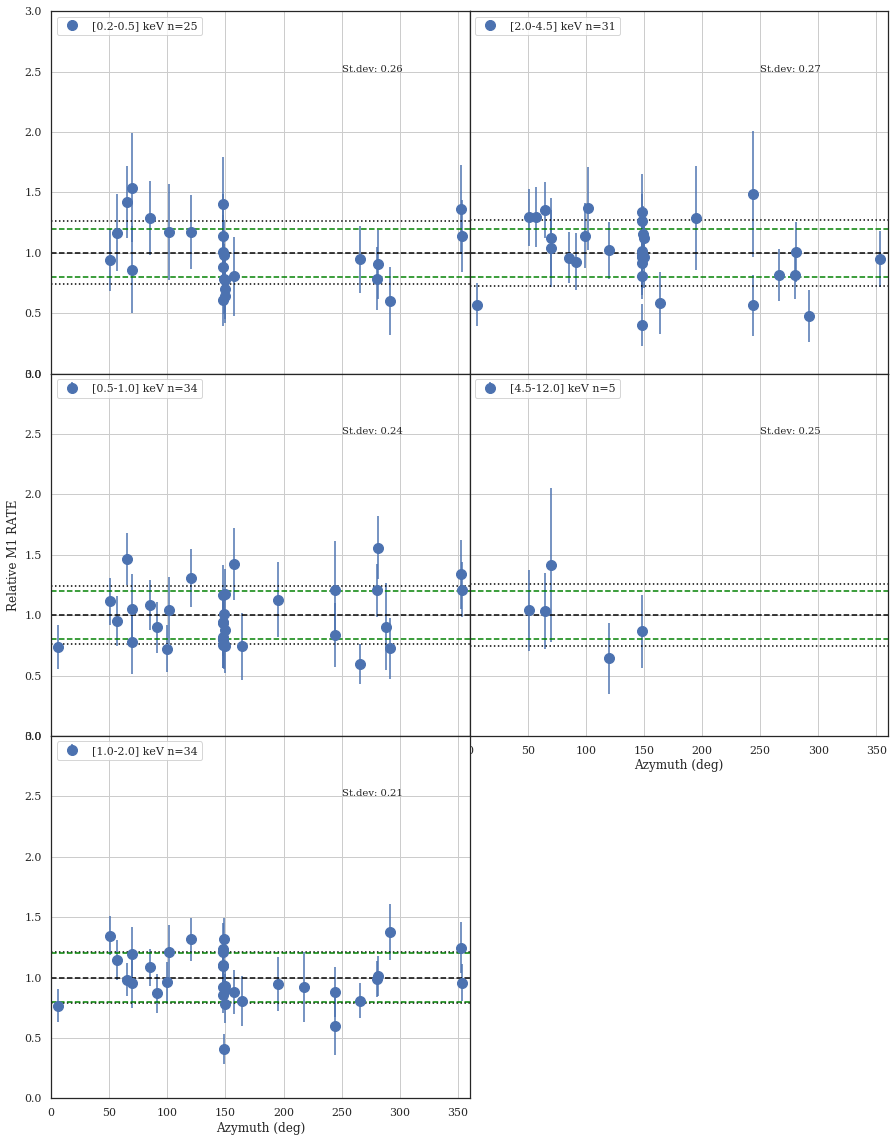

In [17]:
plot_phi(qf,inst='M1',which='RATE',relative=True, ml_limit=5.0)

In [25]:
for j in qf.columns:
    print (j,end=" ")

DETID SRCID DR3SRCID DR3DETID DR3DETDIST DR3SRCDIST DR3MULT DR4SRCID DR4DETID DR4DETDIST DR4SRCDIST DR4MULT IAUNAME SRC_NUM OBS_ID REVOLUT MJD_START MJD_STOP OBS_CLASS PN_FILTER M1_FILTER M2_FILTER PN_SUBMODE M1_SUBMODE M2_SUBMODE RA DEC POSERR LII BII RADEC_ERR SYSERRCC REFCAT POSCOROK RA_UNC DEC_UNC CCDPN PN_RAWX PN_RAWY CCDM1 M1_RAWX M1_RAWY CCDM2 M2_RAWX M2_RAWY EP_1_FLUX EP_1_FLUX_ERR EP_2_FLUX EP_2_FLUX_ERR EP_3_FLUX EP_3_FLUX_ERR EP_4_FLUX EP_4_FLUX_ERR EP_5_FLUX EP_5_FLUX_ERR EP_8_FLUX EP_8_FLUX_ERR EP_9_FLUX EP_9_FLUX_ERR PN_1_FLUX PN_1_FLUX_ERR PN_2_FLUX PN_2_FLUX_ERR PN_3_FLUX PN_3_FLUX_ERR PN_4_FLUX PN_4_FLUX_ERR PN_5_FLUX PN_5_FLUX_ERR PN_8_FLUX PN_8_FLUX_ERR PN_9_FLUX PN_9_FLUX_ERR M1_1_FLUX M1_1_FLUX_ERR M1_2_FLUX M1_2_FLUX_ERR M1_3_FLUX M1_3_FLUX_ERR M1_4_FLUX M1_4_FLUX_ERR M1_5_FLUX M1_5_FLUX_ERR M1_8_FLUX M1_8_FLUX_ERR M1_9_FLUX M1_9_FLUX_ERR M2_1_FLUX M2_1_FLUX_ERR M2_2_FLUX M2_2_FLUX_ERR M2_3_FLUX M2_3_FLUX_ERR M2_4_FLUX M2_4_FLUX_ERR M2_5_FLUX M2_5_FLUX_ERR M2_8_FL

In [56]:
i = 0
print ("%i,%s"%(qf["SRC_NUM"].iloc[0],qf["OBS_ID"].iloc[0].decode()),qf['TSERIES'].iloc[0])

9,0414180801 True


0     False
1     False
2      True
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
Name: VAR_FLAG, dtype: bool

In [39]:
jt.any()

True